# Fast benchmark: Pillow vs OpenCV

*Background: when we deal with images in image-based problems and deploy a deep learning solution, it is better to have a fast image reading and transforming library. Let's compare Pillow and OpenCV python libraries on image loading and some basic transformations on source images from Carvana competition.*

[OpenCV](https://github.com/opencv/opencv): C++, python-wrapper

[Pillow](https://github.com/python-pillow/Pillow): Python, C


`
`

*This question I asked myself after reading the PyTorch [documentation on image transformation](http://pytorch.org/docs/0.2.0/_modules/torchvision/transforms.html). Most of transformations take as input a PIL image.*


In [1]:
import PIL
import cv2

At first, let's get packages versions, specs and some info on the machine

In [2]:
cv2.__version__, cv2.__spec__

('3.3.0-dev',
 ModuleSpec(name='cv2', loader=<_frozen_importlib_external.ExtensionFileLoader object at 0x7fc05fb22e10>, origin='/opt/conda/lib/python3.6/site-packages/cv2.cpython-36m-x86_64-linux-gnu.so'))

In [ ]:
PIL.__version__, PIL.__spec__

In [ ]:
!cat /proc/cpuinfo | egrep "model name"

Data storage info: `ROTA 1` means rotational device

In [5]:
!lsblk -o name,rota,type,mountpoint

NAME   ROTA TYPE MOUNTPOINT
fd0       1 disk 
sda       1 disk 
└─sda1    1 part /kaggle/lib/kagglegym
sdb       1 disk 
└─sdb1    1 part /kaggle/input
sdc       1 disk 
└─sdc1    1 part /etc/hosts
loop0     1 loop 
loop1     1 loop 
loop2     1 loop 
loop3     1 loop 
loop4     1 loop 
loop5     1 loop 
loop6     1 loop 
loop7     1 loop 
loop8     1 loop 
loop9     1 loop 
loop10    1 loop 
loop11    1 loop /dev/sumble/amer
loop13    1 loop 
loop14    1 loop 


Now let's setup the input data

In [6]:
import os
this_path = os.path.dirname('.')

INPUT_PATH = os.path.abspath(os.path.join(this_path, '..', 'input'))
TRAIN_DATA = os.path.join(INPUT_PATH, "train")
from glob import glob
filenames = glob(os.path.join(TRAIN_DATA, "*.jpg"))
len(filenames)

5088

In [7]:
import matplotlib.pylab as plt
%matplotlib inline

## 1 stage: 100 images, load image + blur + flip

In [8]:
import numpy as np
from PIL import Image, ImageOps

def stage_1_PIL(filename):
    img_pil = Image.open(filename)
    img_pil = ImageOps.box_blur(img_pil, radius=3)
    img_pil = img_pil.transpose(Image.FLIP_LEFT_RIGHT)
    return np.asarray(img_pil)

def stage_1_cv2(filename):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.blur(img, ksize=(3, 3))
    img = cv2.flip(img, flipCode=1)
    return img

Let's compare briefly results of transformations on the first image. Results are not perfectly the same, but it is not important for the benchmark  

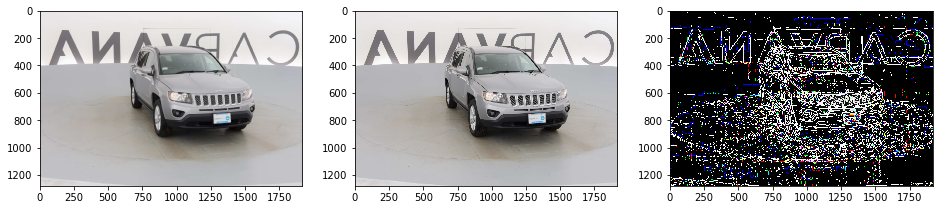

In [9]:
f = filenames[0]
r1 = stage_1_PIL(f) 
r2 = stage_1_cv2(f)

plt.figure(figsize=(16, 16))
plt.subplot(131)
plt.imshow(r1)
plt.subplot(132)
plt.imshow(r2)
plt.subplot(133)
plt.imshow(np.abs(r1 - r2))

In [ ]:
%timeit -n5 -r3 [stage_1_PIL(f) for f in filenames[:100]]

In [ ]:
%timeit -n5 -r3 [stage_1_cv2(f) for f in filenames[:100]]

## 1b stage: 100 images, blur + flip

In [10]:
def stage_1b_PIL(img_pil):
    img_pil = ImageOps.box_blur(img_pil, radius=3)
    img_pil = img_pil.transpose(Image.FLIP_LEFT_RIGHT)
    return np.asarray(img_pil)

def stage_1b_cv2(img):    
    img = cv2.blur(img, ksize=(3, 3))
    img = cv2.flip(img, flipCode=1)
    return img

In [12]:
imgs_PIL = [Image.open(filename) for filename in filenames[:100]]

In [13]:
def cv2_open(filename):
    img = cv2.imread(filename)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

imgs_cv2 = [cv2_open(filename) for filename in filenames[:100]]

In [ ]:
%timeit -n5 -r3 [stage_1b_PIL(img_pil) for img_pil in imgs_PIL]

5 loops, best of 3: 711 ms per loop


In [ ]:
%timeit -n5 -r3 [stage_1b_cv2(img) for img in imgs_cv2]

## 2 stage: 500 images, load image + resize + 2 flips

In [ ]:
import numpy as np
from PIL import Image, ImageOps


def stage_2_PIL(filename):
    img_pil = Image.open(filename)
    img_pil = img_pil.resize((512, 512), Image.CUBIC)
    img_pil = img_pil.transpose(Image.FLIP_LEFT_RIGHT)
    img_pil = img_pil.transpose(Image.FLIP_TOP_BOTTOM)
    return np.asarray(img_pil)

def stage_2_cv2(filename):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
    img = cv2.resize(img, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
    img = cv2.flip(img, flipCode=1)
    img = cv2.flip(img, flipCode=0)
    return img

Again let's compare briefly results of transformations on the first image:

In [ ]:
f = filenames[0]
r1 = stage_2_PIL(f) 
r2 = stage_2_cv2(f)

plt.figure(figsize=(16, 16))
plt.subplot(131)
plt.imshow(r1)
plt.subplot(132)
plt.imshow(r2)
plt.subplot(133)
plt.imshow(np.abs(r1 - r2))

In [ ]:
%timeit -n5 -r3 [stage_2_PIL(f) for f in filenames[:200]]

In [ ]:
%timeit -n5 -r3 [stage_2_cv2(f) for f in filenames[:200]]